### Setting Up

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Utility Functions

In [5]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

### Loading and prepping the data

In [ ]:
#Loading in the Data
df = pd.read_csv("./water_potability.csv")

In [7]:
#Filling in the missing values

#Filling NaN pH Values
df["ph"].fillna(value = df["ph"].mean(), inplace = True)

#Filling NaN Sulfate Values
df["Sulfate"].fillna(value = df["Sulfate"].mean(), inplace = True)

#Filling NaN Trihalomethanes Values
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].mean(), inplace = True)

In [8]:
scaler = StandardScaler()

X_water_2d = df[['ph', 'Chloramines']]
y_water_2d = df['Potability']

X_water_scaled = scaler.fit_transform(X_water_2d)

X_train, X_test, y_train, y_test = train_test_split(X_water_scaled, y_water_2d.to_numpy(), random_state=0)

## a) Neural Network

#### 1 Layer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


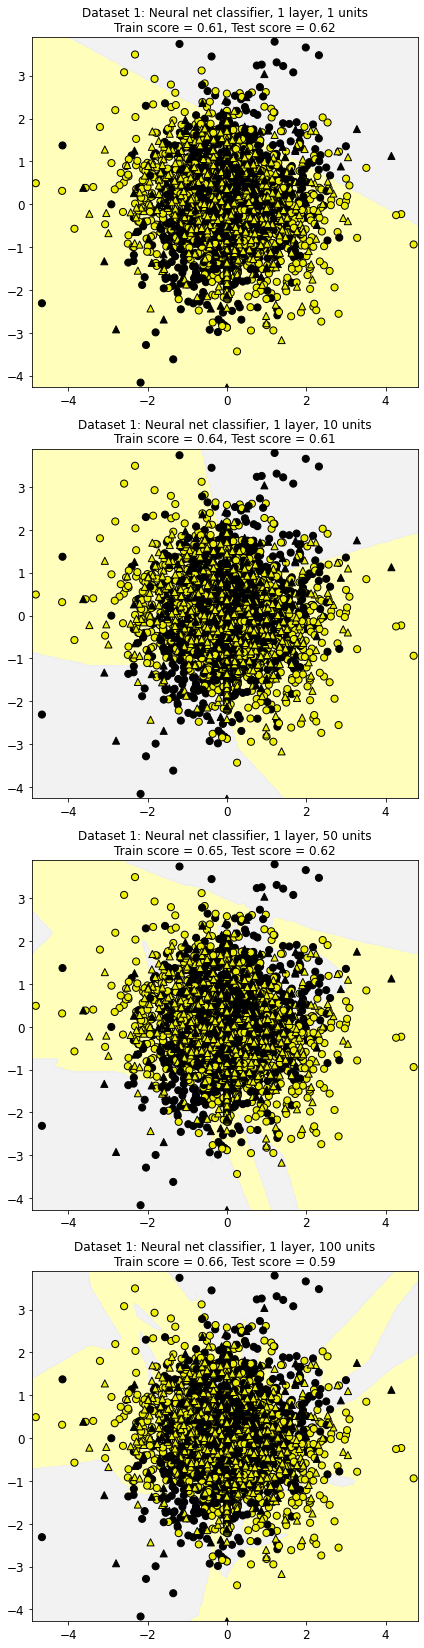

In [29]:
fig, subaxes = plt.subplots(4, 1, figsize=(6,23))

for units, axis in zip([1, 10, 50, 100], subaxes):
    # create a model and training it
    # we may need to increase the number of iterations or scale the data (normalization)
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0, max_iter=1000).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

#### 2 Layer

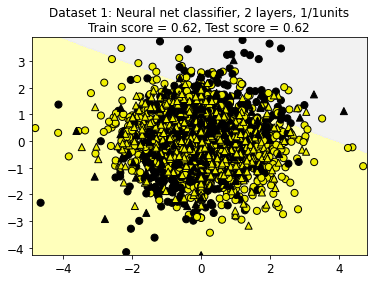

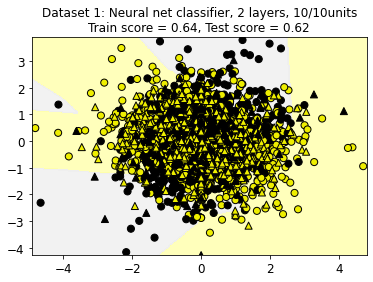

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


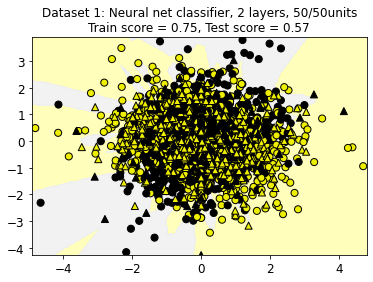

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


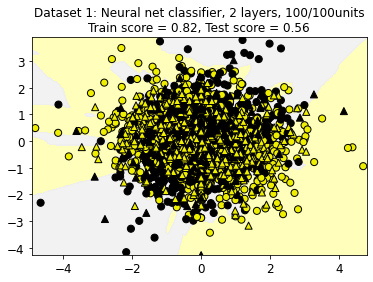

In [36]:
for units in [1, 10, 50, 100]:

    # model training with two hidden layers
    nnclf = MLPClassifier(hidden_layer_sizes = [units, units], solver='lbfgs',
                        random_state = 0, max_iter=10000).fit(X_train, y_train)
    title = 'Dataset 1: Neural net classifier, 2 layers, ' + str(units) + '/' + str(units) + 'units'
    plot_class_regions_for_classifier(nnclf, X_train, y_train,
                                             X_test, y_test, title)

#### Relu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

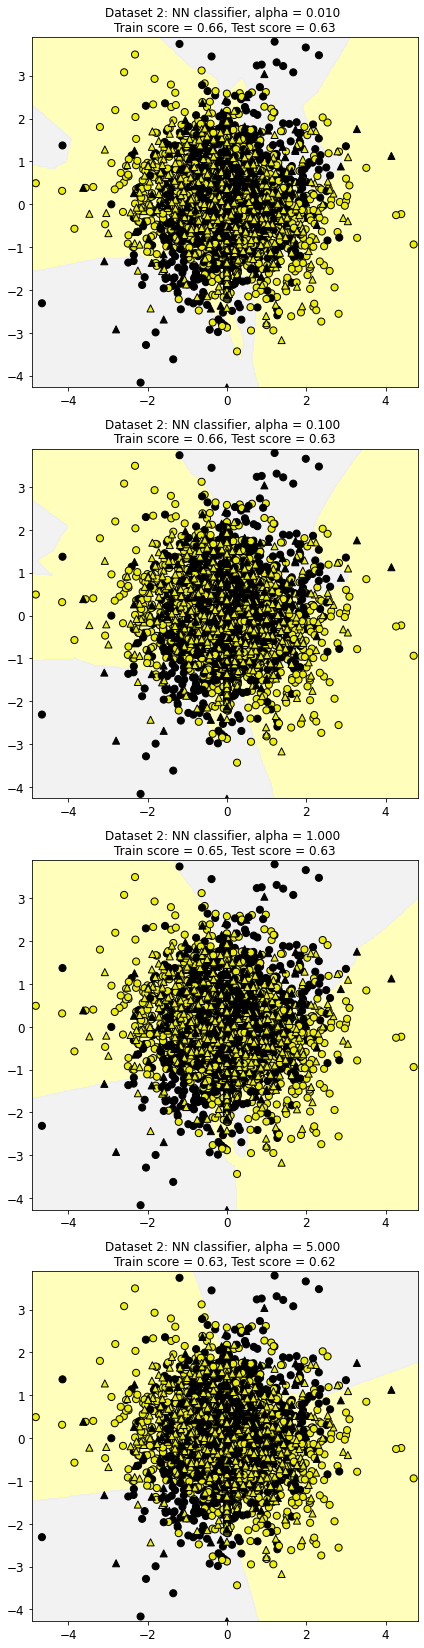

In [11]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

#### Tanh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

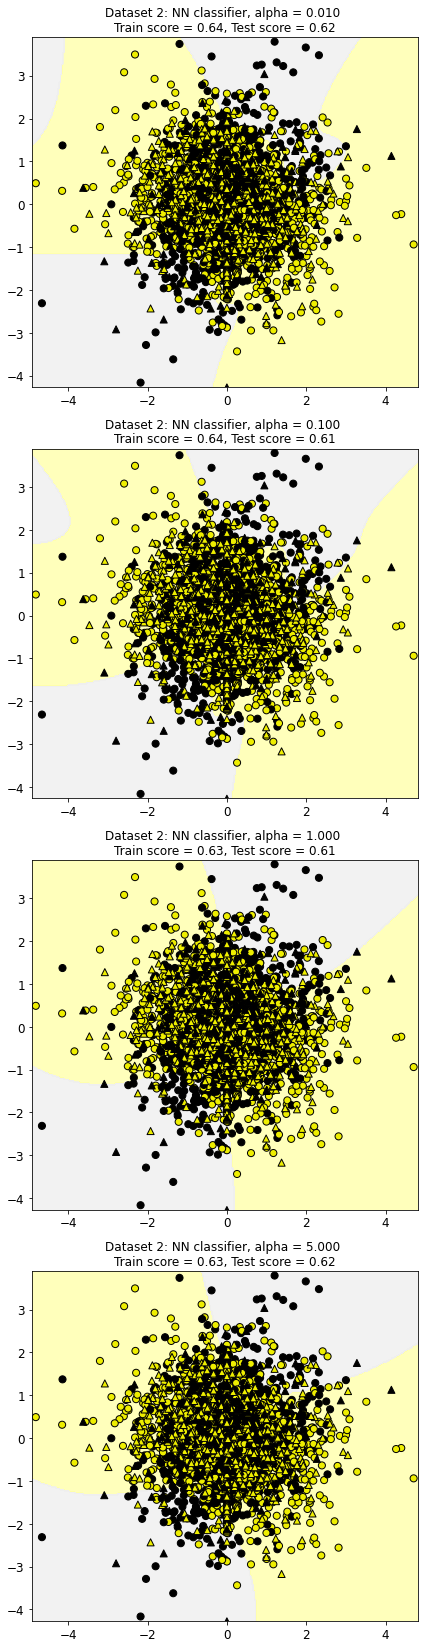

In [12]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

#### Logistic

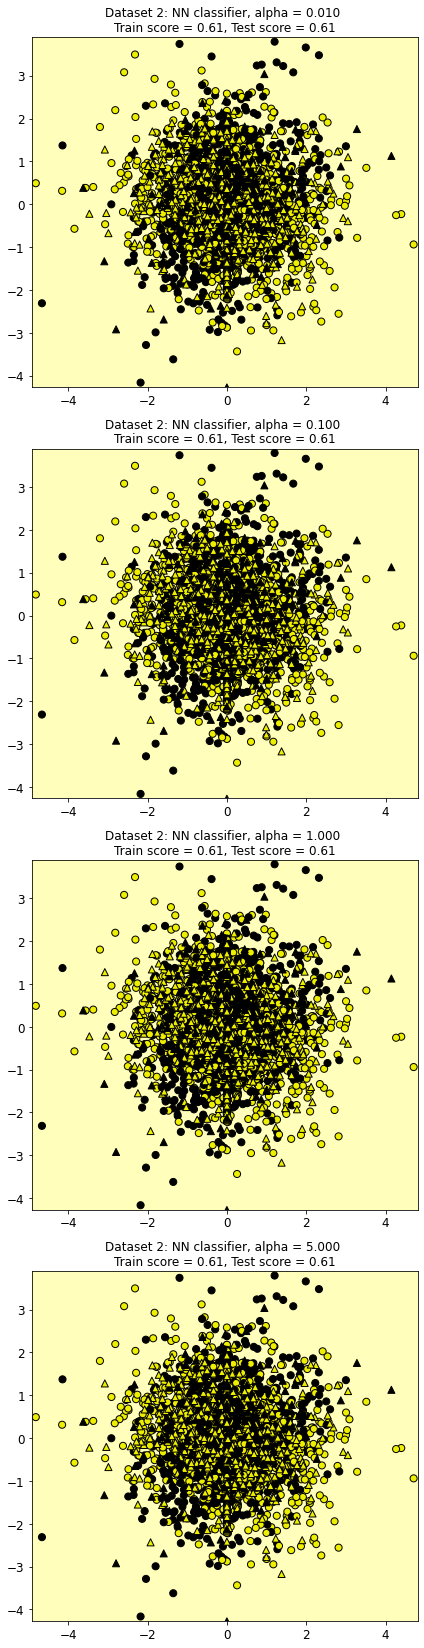

In [13]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'logistic',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Comparison Analysis

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold # import k-fold validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve

In [37]:
models = []
results = []
names = []
scoring = 'accuracy'

models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NN', MLPClassifier()))

for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NB: 0.614077 (0.048401)
KNN: 0.579901 (0.054951)
DT: 0.523803 (0.037826)
NN: 0.614122 (0.041279)


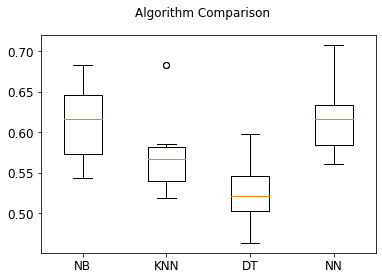

In [38]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Learning Curve

In [17]:
X = X_water_2d
y = np.c_[df['Potability']]

[[0.79595385 0.78313988 0.78787206]
 [0.79876083 0.78356456 0.781516  ]
 [0.78937943 0.78278105 0.78373392]
 [0.78903283 0.78396306 0.78939124]
 [0.79218002 0.7857698  0.7904472 ]]
[[0.79307686 0.79445016 0.78891358]
 [0.79169639 0.79581637 0.79077205]
 [0.78891358 0.79169639 0.78984445]
 [0.78844691 0.79123462 0.79169639]
 [0.78844691 0.79030866 0.79030866]]


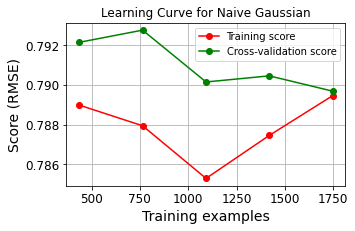

In [18]:
# evaluate the training and testing and retrieve the information of model performance. 

train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(GaussianNB(), X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('Learning Curve for Naive Gaussian')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()


[[0.75276668 0.76713644 0.77216712]
 [0.77244735 0.76597677 0.75557312]
 [0.77006458 0.75826523 0.77747703]
 [0.7776716  0.76421532 0.78139085]
 [0.77400481 0.76005306 0.77707266]]
[[0.78515674 0.79581637 0.7856293 ]
 [0.78468333 0.80910671 0.79123462]
 [0.79490634 0.81040025 0.79627021]
 [0.77893435 0.79215735 0.78420906]
 [0.78891358 0.8021008  0.78984445]]


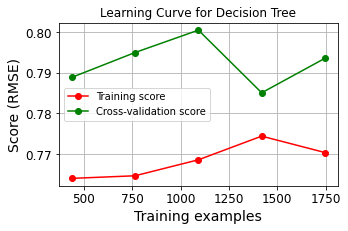

In [19]:
# evaluate the training and testing and retrieve the information of model performance. 

train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(DecisionTreeClassifier(criterion='gini',max_depth=5), X, y, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('Learning Curve for Decision Tree')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[[0.77710134 0.77340954 0.79136603]
 [0.78220064 0.78424385 0.78356456]
 [0.7856293  0.78844691 0.78038353]
 [0.78286379 0.79330187 0.78469335]
 [0.78811891 0.79218002 0.78220612]]
[[0.79030866 0.79030866 0.79030866]
 [0.79581637 0.78984445 0.79030866]
 [0.78984445 0.79030866 0.79030866]
 [0.78984445 0.79030866 0.79030866]
 [0.78937943 0.79030866 0.79169639]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


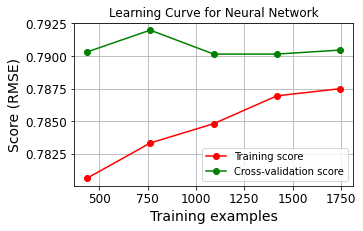

In [20]:
# evaluate the training and testing and retrieve the information of model performance. 

train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(MLPClassifier(), X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('Learning Curve for Neural Network')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

[[0.79391707 0.75263884 0.75854234 0.77088041 0.76240273 0.76526001
  0.76526001 0.78441771 0.76526001 0.77547192]
 [0.78474675 0.75330327 0.76763734 0.77555489 0.76221966 0.75668393
  0.76548406 0.76870722 0.76112215 0.77710964]
 [0.77289779 0.75893196 0.76619896 0.77142419 0.76657575 0.77068422
  0.76544371 0.7750925  0.76278258 0.77581995]
 [0.77522478 0.76377075 0.76200751 0.77155798 0.75724473 0.76668263
  0.7661029  0.7755047  0.76377075 0.77325683]
 [0.76486085 0.76007725 0.7629582  0.77025331 0.76319681 0.76978888
  0.7653343  0.76839053 0.76031858 0.76909066]]
[[0.79037652 0.784128   0.80828319 0.79191572 0.81540532 0.78094688
  0.79252047 0.81177402 0.81882745 0.77832033]
 [0.78882828 0.793446   0.80244683 0.81540532 0.82507312 0.78254229
  0.78630415 0.78943066 0.80453178 0.74549272]
 [0.78570414 0.79648027 0.77446544 0.81540532 0.82234556 0.78570414
  0.78787206 0.78313988 0.80745209 0.75276668]
 [0.78094688 0.793446   0.77610107 0.82234556 0.82911441 0.78727086
  0.7878720

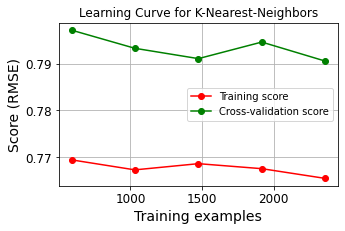

In [21]:
# evaluate the training and testing and retrieve the information of model performance. 

train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(KNeighborsClassifier(n_neighbors=21), X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('Learning Curve for K-Nearest-Neighbors')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

### Ensemble Methods

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

for i in [0.001, 0.01, 0.05, 0.1, 0.15, 0.5, 1]:
    clf = GradientBoostingClassifier(learning_rate = i, max_depth = 5, random_state = 0)
    clf.fit(X_train, y_train)
    print('Water dataset (learning_rate={}, max_depth=5)'.format(i))
    print('Accuracy of GBDT classifier on training set: {:.2f}'
        .format(clf.score(X_train, y_train)))
    print('Accuracy of GBDT classifier on test set: {:.2f}'
        .format(clf.score(X_test, y_test)))
    print()

Water dataset (learning_rate=0.001, max_depth=5)
Accuracy of GBDT classifier on training set: 0.61
Accuracy of GBDT classifier on test set: 0.61

Water dataset (learning_rate=0.01, max_depth=5)
Accuracy of GBDT classifier on training set: 0.65
Accuracy of GBDT classifier on test set: 0.61

Water dataset (learning_rate=0.05, max_depth=5)
Accuracy of GBDT classifier on training set: 0.72
Accuracy of GBDT classifier on test set: 0.60

Water dataset (learning_rate=0.1, max_depth=5)
Accuracy of GBDT classifier on training set: 0.77
Accuracy of GBDT classifier on test set: 0.59

Water dataset (learning_rate=0.15, max_depth=5)
Accuracy of GBDT classifier on training set: 0.85
Accuracy of GBDT classifier on test set: 0.58

Water dataset (learning_rate=0.5, max_depth=5)
Accuracy of GBDT classifier on training set: 0.96
Accuracy of GBDT classifier on test set: 0.56

Water dataset (learning_rate=1, max_depth=5)
Accuracy of GBDT classifier on training set: 0.99
Accuracy of GBDT classifier on test 